In [1]:
! nvidia-smi

Wed Sep 13 12:29:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [6]:
data_dir = '/content/drive/MyDrive/Agrifirst'
train_dir = data_dir + '/Train/image_train'
valid_dir = '/content/drive/MyDrive/Agrifirst/Valid/image_valid'
test_dir = '/content/drive/MyDrive/Agrifirst/Test/image_test'

In [7]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.utils import to_categorical
import numpy as np
import os, shutil

In [8]:
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [9]:
newpath = '/content/drive/MyDrive/Agrifirst/Testing_Path'
if not os.path.exists(newpath):
    os.makedirs(newpath)

x = os.listdir(train_dir)
for dir_names in x:
  # print(dir_names)
  p = os.listdir(os.path.join(train_dir, dir_names))
  if not os.path.exists(os.path.join(newpath, dir_names)):
    os.makedirs(os.path.join(newpath, dir_names))
  cnt = 0
  file_names = []
  for image_names in p:
    if cnt==250:
      break
    file_names.append(train_dir+'/'+dir_names+'/'+image_names)
    cnt += 1
  for f in file_names:
    shutil.move(f, os.path.join(newpath, dir_names))




In [10]:
train_datagen = ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False
                                  ,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)

val_datagen = ImageDataGenerator()

train = train_datagen.flow_from_directory(directory=train_dir,batch_size=32,target_size=(224,224),
                                         color_mode='rgb',class_mode='categorical',seed=42)

valid = val_datagen.flow_from_directory(directory=valid_dir,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='categorical')

test_datagen = ImageDataGenerator()

test = test_datagen.flow_from_directory(directory=test_dir,batch_size=32,target_size=(224,224),color_mode='rgb',class_mode='categorical')

Found 40797 images belonging to 48 classes.
Found 51142 images belonging to 48 classes.
Found 51142 images belonging to 48 classes.


In [11]:
base_model_tf=EfficientNetV2S(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=48)

82420632/82420632 [==============================] - 0s 0us/step


In [17]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) #This function used to zero-center each color channel wrt Imagenet dataset
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(128,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(48,activation='softmax')(model_resnet)


model_main=Model(inputs=pt,outputs=model_resnet)
model_main.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_2 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Function  (None, 7, 7, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_6 (Dense)             (None, 128)               163968    
                                                                 
 dense_7 (Dense)             (None, 64)                8256

In [18]:
es=EarlyStopping(monitor='accuracy',verbose=1,patience=5,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)

In [19]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
model_main.fit(train,validation_data=valid,epochs=20,steps_per_epoch=200,verbose=1,callbacks=[es, lr])

Epoch 1/20
200/200 [==============================] - 391s 2s/step - loss: 1.4969 - accuracy: 0.5897 - val_loss: 0.9167 - val_accuracy: 0.7778 - lr: 0.0010
Epoch 2/20
200/200 [==============================] - 339s 2s/step - loss: 0.5268 - accuracy: 0.8373 - val_loss: 0.7190 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 3/20
200/200 [==============================] - 318s 2s/step - loss: 0.3790 - accuracy: 0.8787 - val_loss: 0.6388 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 4/20
200/200 [==============================] - 309s 2s/step - loss: 0.3031 - accuracy: 0.9025 - val_loss: 0.6767 - val_accuracy: 0.8737 - lr: 0.0010
Epoch 5/20
200/200 [==============================] - 366s 2s/step - loss: 0.2672 - accuracy: 0.9139 - val_loss: 0.6053 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 6/20
200/200 [==============================] - 309s 2s/step - loss: 0.2442 - accuracy: 0.9191 - val_loss: 0.5896 - val_accuracy: 0.9050 - lr: 0.0010
Epoch 7/20
200/200 [==============================] - 316s 2s/st

In [22]:

model_main.save("efficientnetv2s_PLANT_DISEASE_new_new.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
model_main.save('/content/drive/MyDrive/saved_model/PD_model.h5')

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

Text(0.5, 1.0, 'model loss')

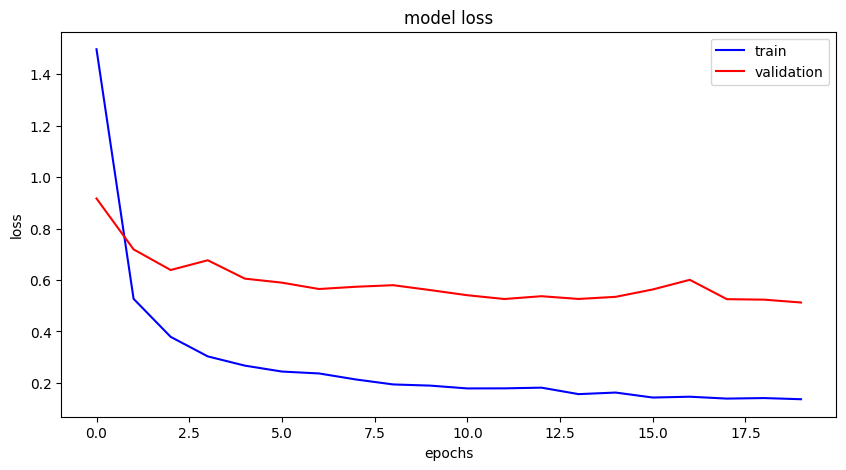

In [26]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.title("model loss")

Text(0.5, 1.0, 'model accuracy')

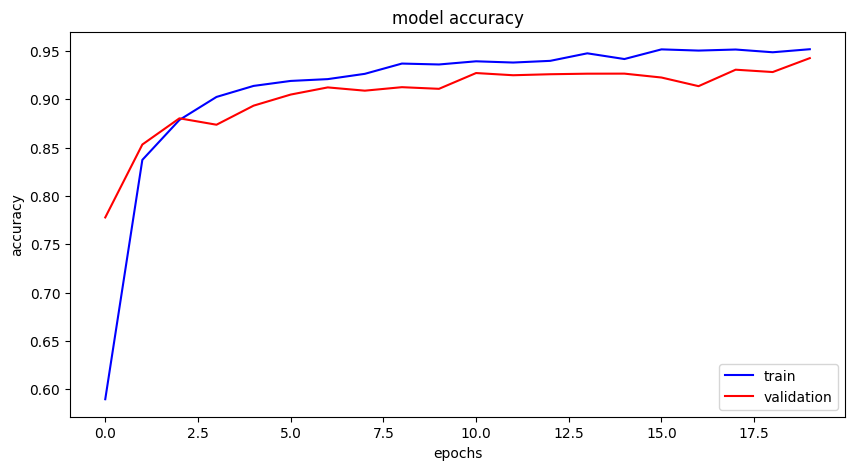

In [27]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.title("model accuracy")

In [28]:
loss, accuracy = model_main.evaluate(train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(valid, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

1275/1275 [==============================] - 656s 515ms/step - loss: 0.1116 - accuracy: 0.9621
Train: accuracy = 0.962130  ;  loss = 0.111555
1599/1599 [==============================] - 223s 139ms/step - loss: 0.5125 - accuracy: 0.9426
Validation: accuracy = 0.942650  ;  loss = 0.512522
1599/1599 [==============================] - 252s 157ms/step - loss: 0.5125 - accuracy: 0.9426
Test: accuracy = 0.942650  ;  loss = 0.512522


In [29]:
model = load_model("/content/drive/MyDrive/saved_model/PD_model.h5")

In [30]:
img = tensorflow.keras.utils.load_img(
    "/content/drive/MyDrive/Agrifirst/Testing_Path/Aloevera___rust/ru1 (100).jpg",
    target_size=(224, 224, 3)
)
input_arr = tensorflow.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
result = model.predict(input_arr)

1/1 [==============================] - 51s 51s/step


In [31]:
probability_model = tensorflow.keras.Sequential([model,
                                         tensorflow.keras.layers.Softmax()])

In [32]:
predict = probability_model.predict(input_arr)

1/1 [==============================] - 6s 6s/step


In [33]:
predict[0]

array([0.02011335, 0.02011373, 0.05467239, 0.02011336, 0.02011335,
       0.02011337, 0.02011334, 0.02011334, 0.02011336, 0.02011334,
       0.02011334, 0.02011334, 0.02011334, 0.02011334, 0.02011334,
       0.02011334, 0.02011334, 0.02011334, 0.02011334, 0.02011334,
       0.02011334, 0.02011334, 0.02011334, 0.02011334, 0.02011334,
       0.02011334, 0.02011334, 0.02011334, 0.02011334, 0.02011334,
       0.02011334, 0.02011334, 0.02011334, 0.02011334, 0.02011334,
       0.02011334, 0.02011334, 0.02011334, 0.02011334, 0.02011334,
       0.02011338, 0.02011334, 0.02011334, 0.02011334, 0.02011334,
       0.02011334, 0.02011334, 0.02011334], dtype=float32)

In [34]:
classes = ['Aloevera___healthy_leaf', 'Aloevera___rot', 'Aloevera___rust', 'Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Rose___Healthy_Leaf', 'Rose___Rust', 'Rose___sawfly_Rose_slug', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tea___algal leaf', 'Tea___Anthracnose', 'Tea___bird eye spot', 'Tea___brown blight', 'Tea___gray light', 'Tea___healthy', 'Tea___red leaf spot', 'Tea___white spot', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']


In [35]:
p = np.argmax(predict[0])
print(classes[p])

Aloevera___rust
